# Gene distance 5 tissue consistent

In [3]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [4]:
from seaborn.categorical import _BoxPlotter


class box_plotter(_BoxPlotter):
    def add_statistic_annotate(self, ax, x1, x2, y, h, value, text_type,
                               **kws):
        default_lw = mpl.rcParams["patch.linewidth"]
        lw = kws.get("linewidth", kws.get("lw", default_lw))
        width = x2 - x1
#         x1, x2 = x1 + .1 * width, x2 - .1 * width
#         x1, x2 = x1 + .5, x2 - .5
        ax.plot([x1, x1, x2, x2], [y - .5 * h, y, y, y - .5 * h],
                lw=1.5,
                c='k')
        if text_type == 'raw':
            ax.text((x1 + x2) * .5,
                    y + h * .1,
                    f'P = {value:.2e}',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.05:
            ax.text((x1 + x2) * .5,
                    y + h * .1,
                    'n.s.',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.01:
            ax.text((x1 + x2) * .5,
                    y + h * .1,
                    '*',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.001:
            ax.text((x1 + x2) * .5,
                    y_ + h * .1,
                    '**',
                    ha='center',
                    va='bottom',
                    color='k')
        else:
            ax.text((x1 + x2) * .5,
                    y + h * .1,
                    '***',
                    ha='center',
                    va='bottom',
                    color='k')

    def draw_statistic_annotate(self, ax, centerCol, **kwargs):
        from operator import methodcaller
        from scipy import stats
        if kwargs.get('statistic_test') == 'mannwhitneyu':
            statistic_kwargs = {
                'use_continuity': kwargs.get('use_continuity', True),
                'alternative': kwargs.get('alternative', None)
            }
        elif kwargs.get('statistic_test') == 'wilcoxon':
            statistic_kwargs = {
                'zero_method': kwargs.get('zero_method', 'wilcox'),
                'correction': kwargs.get('correction', False),
                'alternative': kwargs.get('alternative', 'two-sided')
            }
        elif kwargs.get('statistic_test') == 'ttest_ind':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'equal_var': kwargs.get('equal_var', True),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        elif kwargs.get('statistic_test') == 'ttest_rel':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        else:
            raise ValueError(
                'statistic_test must be either mannwhitneyu, wilcoxon, ttest_ind or ttest_rel.'
            )
        ylim = ax.get_ylim()
        h = .05 * (ylim[1] - ylim[0])
#         print(self.plot_hues)
        if self.plot_hues is None:
            if centerCol == None :
                for i in range(len(self.plot_data) - 1):
                    pvalue = methodcaller(kwargs.get('statistic_test'),
                                          self.plot_data[i], self.plot_data[i + 1],
                                          **statistic_kwargs)(stats).pvalue
                    
                    Q1_1 = np.quantile(self.plot_data[i], .25)
                    Q1_2 = np.quantile(self.plot_data[i+1], .25)
                    Q3_1 = np.quantile(self.plot_data[i], .75)
                    Q3_2 = np.quantile(self.plot_data[i+1], .75)
                    IQR_1 = Q3_1 - Q1_1
                    IQR_2 = Q3_2 - Q1_2
                    y = max(Q3_1 + 1.5 * IQR_1, Q3_2 + 1.5 * IQR_2) + .5 * h
                    self.add_statistic_annotate(ax,
                                                i,
                                                i + 1,
                                                y,
                                                h,
                                                pvalue,
                                                text_type=kwargs.get(
                                                    'text_type', 'raw'))
            else :
                for i in range(len(self.plot_data)):
                    if i != centerCol :
                        pvalue = methodcaller(kwargs.get('statistic_test'),
                                              self.plot_data[i], self.plot_data[centerCol],
                                              **statistic_kwargs)(stats).pvalue
                        
                        Q1_1 = np.quantile(self.plot_data[i], .25)
                        Q1_2 = np.quantile(self.plot_data[centerCol], .25)
                        Q3_1 = np.quantile(self.plot_data[i], .75)
                        Q3_2 = np.quantile(self.plot_data[centerCol], .75)
                        IQR_1 = Q3_1 - Q1_1
                        IQR_2 = Q3_2 - Q1_2
#                         y = max(Q3_1 + 1.5 * IQR_1, Q3_2 + 1.5 * IQR_2) + .5 * h * np.absolute(centerCol - i)
                        y = max(Q3_1 + 1.5 * IQR_1, Q3_2 + 1.5 * IQR_2) + .25 * h * np.absolute(centerCol - i)
                        self.add_statistic_annotate(ax,
                                                    i,
                                                    centerCol,
                                                    y,
                                                    h,
                                                    pvalue,
                                                    text_type=kwargs.get(
                                                        'text_type', 'raw'))
                    
        else:
            for i in range(len(self.plot_data)):
                offsets = self.hue_offsets
                for j in range(len(self.hue_names) - 1):
                    pvalue = methodcaller(
                        kwargs.get('statistic_test'), self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j]],
                        self.plot_data[i][self.plot_hues[i] == self.hue_names[
                            j + 1]], **statistic_kwargs)(stats).pvalue
                    Q1_1 = np.quantile(self.plot_data[i], .25)
                    Q1_2 = np.quantile(self.plot_data[i+1], .25)
                    Q3_1 = np.quantile(self.plot_data[i], .75)
                    Q3_2 = np.quantile(self.plot_data[i+1], .75)
                    IQR_1 = Q3_1 - Q1_1
                    IQR_2 = Q3_2 - Q1_2
                    y = max(Q3_1 + 1.5 * IQR_1, Q3_2 + 1.5 * IQR_2) + .5 * h
                    self.add_statistic_annotate(ax,
                                                i + offsets[j],
                                                i + offsets[j + 1],
                                                y,
                                                h,
                                                pvalue,
                                                text_type=kwargs.get(
                                                    'text_type', 'raw'))
    
        ax.set_ylim(ylim[0], ylim[1] + 1.5 * h)


def boxplot(x=None,
            y=None,
            hue=None,
            data=None,
            order=None,
            hue_order=None,
            orient=None,
            color=None,
            palette=None,
            saturation=0.75,
            width=0.8,
            dodge=True,
            fliersize=5,
            linewidth=None,
            whis=1.5,
            ax=None,
            statistic_args=None,
            centerCol=None,
            **kwargs):
    plotter = box_plotter(x, y, hue, data, order, hue_order, orient, color,
                          palette, saturation, width, dodge, fliersize,
                          linewidth)
    if ax is None:
        ax = plt.gca()
    kwargs.update(dict(whis=whis))
    plotter.draw_boxplot(ax, kwargs)
    plotter.annotate_axes(ax)
    if statistic_args:
        kwargs = statistic_args
        plotter.draw_statistic_annotate(ax, centerCol, **kwargs)
    if plotter.orient == "h":
        ax.invert_yaxis()

# distance to gene TSS

In [15]:
%%bash
### Universal CHM
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table
mkdir -p distance_from_gene
for compart in A B;do
    bedtools closest -b /mnt/Storage/home/yanghui/annotations/mm10/mm10.TSS.refGene.bed -a <(cut -f 1-3 intersectOnly_UniversalCHM_5tissue_${compart}.bed) -d > distance_from_gene/TSS_distance_UniversalCHM_${compart}.bed
done

In [16]:
%%bash
### nonCHM
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/nonCHM_intersect_table
mkdir -p distance_from_gene
for compart in A B;do
    bedtools closest -b /mnt/Storage/home/yanghui/annotations/mm10/mm10.TSS.refGene.bed -a <(cut -f 1-3 intersectOnly_nonCHM_5tissue_${compart}.bed) -d > distance_from_gene/TSS_distance_nonCHM_${compart}.bed
done

In [17]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue')
tss_distance_df = pd.DataFrame()
for compart in ['A', 'B'] :
    for t in ['UniversalCHM', 'nonCHM'] :
        t_short = 'CHM' if t == 'UniversalCHM' else t
        df = pd.read_csv(f'{t_short}_intersect_table/distance_from_gene/TSS_distance_{t}_{compart}.bed',
                                      sep = "\t", header = None, names = [ 
                                                                          'CHM_chr', 'CHM_start', 'CHM_end', 
                                                                          'chr', 'start', 'end', 'Transcript_id', 'score', 'strand',
                                                                          'distance']
                                     )
        df['Type'] = t
        df['compart'] = compart
        tss_distance_df = pd.concat([tss_distance_df, df])
    

tss_distance_df

,CHM_chr,CHM_start,CHM_end,chr,start,end,Transcript_id,score,strand,distance,Type,compart
0,chr1,34347200,34351500,chr1,34433199,34433200,NR_039562,0,-,81700,UniversalCHM,A
1,chr1,35788600,35795300,chr1,36068399,36068400,NM_015818,0,+,273100,UniversalCHM,A
2,chr1,37278600,37283600,chr1,37299837,37299838,NM_001290797,0,+,16238,UniversalCHM,A
3,chr1,37278600,37283600,chr1,37299837,37299838,NM_030266,0,+,16238,UniversalCHM,A
4,chr1,38704600,38709050,chr1,38627244,38627245,NM_001290814,0,-,77356,UniversalCHM,A
...,...,...,...,...,...,...,...,...,...,...,...,...
1249,chr9,88858000,88859000,chr9,88858967,88858968,NR_166623,0,+,0,nonCHM,B
1250,chr9,88858000,88859000,chr9,88858967,88858968,NR_166624,0,+,0,nonCHM,B
1251,chr9,89622000,89623000,chr9,89622986,89622987,NM_153509,0,-,0,nonCHM,B
1252,chr9,89623000,89624000,chr9,89622986,89622987,NM_153509,0,-,14,nonCHM,B


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nonCHM_A v.s. nonCHM_B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.030e-08 U_stat=1.444e+07
UniversalCHM_A v.s. UniversalCHM_B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.854e-90 U_stat=2.352e+05


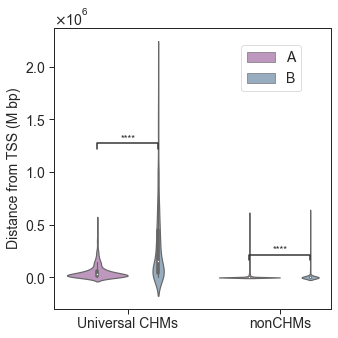

In [29]:
from statannot import add_stat_annotation

with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 14,
                             'legend.fontsize': 14,
                             'legend.title.fontsize': 14
                         }):

            
    fig, ax = plt.subplots(figsize = (6.4 * .75, 4.8 * 1), tight_layout = True)
    sns.violinplot(
        data = tss_distance_df,
        x = 'Type',
        y = 'distance',
        hue = 'compart',
        ax = ax,
#         showfliers = False,
#         width = 0.618,
        palette = ['#C490C6', '#90ADC6'],
        boxprops=dict(alpha=.75),
    )
    add_stat_annotation(ax, data=tss_distance_df, x='Type', y='distance', hue = 'compart',
                        box_pairs=[((x.get_text(), 'A'), (x.get_text(), 'B')) for x in ax.get_xticklabels()],
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    h,l = ax.get_legend_handles_labels()
    ax.legend(h,l, loc = 'lower left', title = "", bbox_to_anchor=(.65, .75))
#     ax.set_title('Distance of universal CHM to nearest TSS of genes\n')
    ax.set_ylabel('Distance from TSS (M bp)')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['Universal CHMs', 'nonCHMs']) 
    ax.set_xlabel('')
    ax.ticklabel_format(axis = 'y', style = 'scientific', useMathText=True)
    
#     fig.savefig('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_box_CHM_distance_to_TSS_5tissue.pdf', transparent = True)

In [87]:
[((x.get_text(), 'A'), (x.get_text(), 'B')) for x in ax.get_xticklabels()]

[(('$\\mathdefault{10^{-2}}$', 'A'), ('$\\mathdefault{10^{-2}}$', 'B')),
 (('$\\mathdefault{10^{0}}$', 'A'), ('$\\mathdefault{10^{0}}$', 'B')),
 (('$\\mathdefault{10^{2}}$', 'A'), ('$\\mathdefault{10^{2}}$', 'B')),
 (('$\\mathdefault{10^{4}}$', 'A'), ('$\\mathdefault{10^{4}}$', 'B')),
 (('$\\mathdefault{10^{6}}$', 'A'), ('$\\mathdefault{10^{6}}$', 'B')),
 (('$\\mathdefault{10^{8}}$', 'A'), ('$\\mathdefault{10^{8}}$', 'B')),
 (('$\\mathdefault{10^{10}}$', 'A'), ('$\\mathdefault{10^{10}}$', 'B'))]

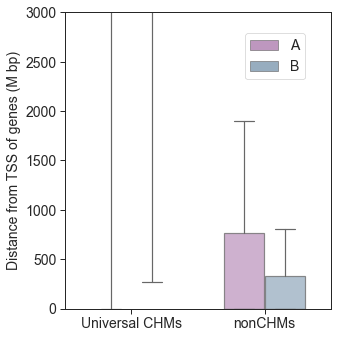

In [51]:
from statannot import add_stat_annotation

with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 14,
                             'legend.fontsize': 14,
                             'legend.title.fontsize': 14
                         }):

            
    fig, ax = plt.subplots(figsize = (6.4 * .75, 4.8 * 1), tight_layout = True)
    sns.boxplot(
        data = tss_distance_df,
        x = 'Type',
        y = 'distance',
        hue = 'compart',
        ax = ax,
        showfliers = False,
        width = 0.618,
        palette = ['#C490C6', '#90ADC6'],
        boxprops=dict(alpha=.75),
        flierprops={"marker": "x", "markersize": 1},
    )
#     add_stat_annotation(ax, data=tss_distance_df, x='Type', y='distance', hue = 'compart',
#                         box_pairs=[((x.get_text(), 'A'), (x.get_text(), 'B')) for x in ax.get_xticklabels()],
#                         test='t-test_welch', text_format='star', loc='inside', verbose=2)
    h,l = ax.get_legend_handles_labels()
    ax.legend(h,l, loc = 'lower left', title = "", bbox_to_anchor=(.65, .75))
#     ax.set_title('Distance of universal CHM to nearest TSS of genes\n')
    ax.set_ylabel('Distance from TSS of genes (M bp)')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['Universal CHMs', 'nonCHMs']) 
    ax.set_xlabel('')
#     ax.ticklabel_format(axis = 'y', style = 'scientific', useMathText=True)
    ax.set_ylim(0,3000)
    
#     fig.savefig('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_box_CHM_distance_to_gene_5tissue_consistent.pdf', transparent = True)

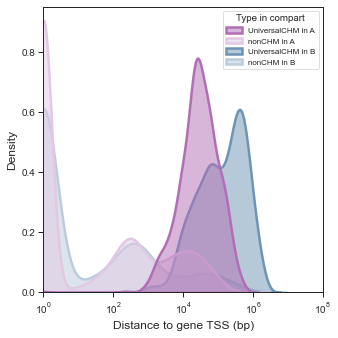

In [86]:

from statannot import add_stat_annotation

with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 12,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    df = tss_distance_df.copy().reset_index()
    df['distance'] = df['distance'] + 1
    df['Type in compart'] = df['Type'] + ' in ' + df['compart']
    fig, axes = plt.subplots(figsize = (6.4 * .75, 4.8 * 1), tight_layout = True, sharex = True)
    ax = axes
    sns.kdeplot(
        data=df, 
        x="distance", 
        hue="Type in compart",
       fill=True, common_norm=False, palette=['#B26EB5', '#E2C8E3', '#6E94B5', '#BBCDDC'],
       alpha=.5, linewidth=2.5,
        ax = ax,
        log_scale = True
    )
#         sns.move_legend(ax, "upper left")
    ax.set_xlim(1,100000000)
#         ax.set_title(f'Distance of universal CHM to nearest TSS of genes\n({cell_type})')
#         ax.set_yscale('log')
#     ax.set_ylabel(f'Density of {t}')
    ax.set_xlabel('Distance to gene TSS (bp)')
    fig.savefig('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_kde_CHM_ABcompart_distance_to_geneTSS_5tissue_consistent.pdf', transparent = True)